In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
mpl.rcParams['figure.figsize'] = (10,5)
sns.set_style('dark')
sns.set_context('talk')

In [168]:
import math
import random
from collections import deque

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from IPython.display import clear_output

In [35]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
means = np.load('./data/L96TwoLevel_means.npy')
variances = np.load('./data/L96TwoLevel_variances.npy')

In [5]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc')

In [6]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [31]:
low = targets.min()
high = targets.max()
low, high

(-6.985977990654064, 3.653016703479749)

In [7]:
slope, intercept =np.polyfit(np.ravel(h.X.values), np.ravel(h.B.values), 1)

## Create wrong linear regression with PyTorch

In [8]:
l96_wrong = L96TwoLevel(X_init=initX, Y_init=initY, F=10, h=1.5, c=7, b=5)

In [9]:
l96_wrong.iterate(20)

In [10]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

In [11]:
np.polyfit(features_wrong, targets_wrong, 1)

array([-0.65506889, -0.20173986])

In [142]:
class LRNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.linear = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.linear(x)

In [143]:
lrnet = LRNet()

In [144]:
optimizer = optim.Adam(lrnet.parameters())
criterion = nn.MSELoss()

In [145]:
bs = 32
nepochs = 30
nbatches = len(features_wrong) // bs
losses = []
for epoch in tqdm(range(nepochs)):
    rand_idxs = np.random.shuffle(np.arange(len(features_wrong)))
    for batch in range(nbatches):
        X = torch.FloatTensor(features_wrong[batch*bs:(batch+1)*bs])[:, None]
        Y = torch.FloatTensor(targets_wrong[batch*bs:(batch+1)*bs])[:, None]
        
        preds = lrnet(X)
        loss = criterion(preds, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        

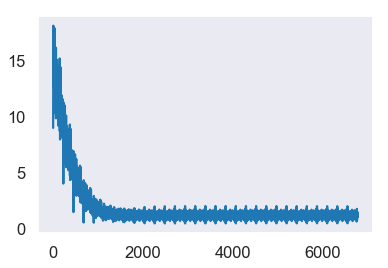

In [146]:
plt.plot(losses)

In [147]:
lrnet.linear.weight, lrnet.linear.bias

(Parameter containing:
 tensor([[-0.6515]], requires_grad=True), Parameter containing:
 tensor([-0.1994], requires_grad=True))

In [148]:
torch.save(lrnet.state_dict(), f'./lr.pt')

## Set up Net L96

In [53]:
class NNParam():
    def __init__(self, net):
        self.net = net
    def __call__(self, x):
        x = torch.FloatTensor(x)[:, None].to(device)
        return self.net(x).cpu().detach().numpy().squeeze(-1)

In [62]:
class L96TwoLevelRL(L96TwoLevel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def step_with_B(self, B):

        k1_X = self._rhs_X_dt(self.X, B=B)
        k2_X = self._rhs_X_dt(self.X + k1_X / 2, B=B)
        k3_X = self._rhs_X_dt(self.X + k2_X / 2, B=B)
        k4_X = self._rhs_X_dt(self.X + k3_X, B=B)

        self.X += 1 / 6 * (k1_X + 2 * k2_X + 2 * k3_X + k4_X)

        self.step_count += 1
        if self.step_count % self.save_steps == 0:
            Y_mean = self.Y.reshape(self.K, self.J).mean(1)
            Y2_mean = (self.Y.reshape(self.K, self.J)**2).mean(1)
            self._history_X.append(self.X.copy())
            self._history_Y_mean.append(Y_mean.copy())
            self._history_Y2_mean.append(Y2_mean.copy())
            self._history_B.append(B.copy())
            if not self.noYhist:
                self._history_Y.append(self.Y.copy())


In [190]:
lrnet = LRNet()
lrnet.load_state_dict(torch.load('./lr.pt'))
nn_param = NNParam(lrnet.to(device))

In [191]:
l96_param = L96TwoLevelRL(noYhist=True, parameterization=nn_param, X_init=initX, Y_init=initY)

In [103]:
B = nn_param(l96_param.X)

In [104]:
#l96_param.step_with_B(B)
l96_param.step()

In [105]:
l96_param.history.B

<xarray.DataArray 'B' (time: 1, x: 36)>
array([[-3.123795, -1.743257, -0.754289, -1.653693, -1.56028 ,  1.435888,
        -1.583193, -1.252386, -1.907032, -1.829945, -2.554658, -0.270472,
         1.58058 ,  0.374701, -3.384294, -1.618283, -0.407961,  0.315627,
         0.721769, -0.93605 , -2.334137, -2.097964,  0.623506, -0.163748,
        -1.189128, -1.638508, -2.379115, -1.691533,  0.479617,  0.07934 ,
        -0.895414, -2.765422, -2.540756, -1.311422,  1.185189,  0.648843]])
Coordinates:
  * time     (time) float64 0.0
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35

In [107]:
l96_tru = L96TwoLevel(X_init=initX, Y_init=initY)
l96_tru.iterate(1)

In [108]:
X_tru = l96_tru.X

In [192]:
l96_param.iterate(1)

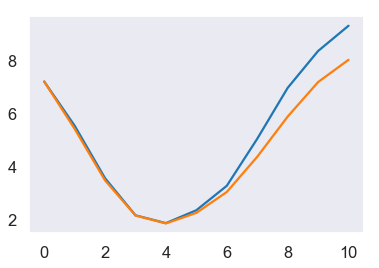

In [193]:
plt.plot(l96_tru.history.X[:, 0])
plt.plot(l96_param.history.X[:, 0])

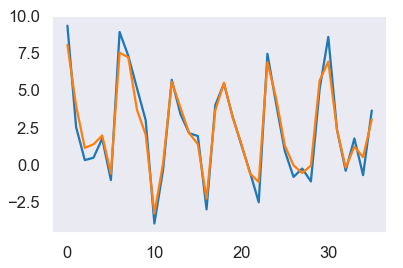

In [194]:
plt.plot(l96_tru.history.X[-1])
plt.plot(l96_param.history.X[-1])

In [195]:
((l96_tru.history.X[-1] - l96_param.history.X[-1])**2).mean()

<xarray.DataArray 'X' ()>
array(0.604862)
Coordinates:
    time     float64 1.0

## Set up RL basics from RL-Adventure

In [196]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [197]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).unsqueeze(1).to(device)
    action     = torch.FloatTensor(action).unsqueeze(1).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [198]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        for s, a, r, ns, d in zip(state, action, reward, next_state, done):
            self.buffer.append([s, a, r, ns, d])
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [209]:
def plot(episode, rewards, weights, biases):
    clear_output(True)
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].set_title('frame %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    axs[0].plot(rewards)
    axs[1].set_title('weight')
    axs[1].plot(weights)
    axs[1].axhline(slope, c='gray')
    #axs[1].set_yscale('log')
    axs[2].set_title('bias')
    axs[2].plot(biases)
    axs[2].axhline(intercept, c='gray')
    plt.show()

In [235]:
lrnet = LRNet()
lrnet.load_state_dict(torch.load('./lr.pt'))
value_net  = ValueNetwork(1, 1, 32).to(device)
policy_net = lrnet.to(device)

target_value_net  = ValueNetwork(1, 1, 32).to(device)
target_policy_net = LRNet().to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [236]:
nn_param = NNParam(policy_net)

In [237]:
targets.std()

1.2555234200229437

In [238]:
max_frames  = 12000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

nepisodes = 100
nsteps = 1000
noise = 0.5

In [239]:
def noise(step):
    epsilon_start = 1
    epsilon_final = 0.1
    epsilon_decay = 20000
    epsilon =(
        epsilon_final + (epsilon_start - epsilon_final) * 
        np.exp(-1. * step / epsilon_decay)
    )
    return epsilon

In [242]:
def learn(nepisodes, step=0):
    error = []
    weights = []
    biases = []
    tbar = tqdm(range(nepisodes))
    for episode in tbar:
        # Start a new run!
        l96_param = L96TwoLevelRL(noYhist=True, parameterization=nn_param, 
                                X_init=initX, Y_init=initY)
        state = l96_param.X
        for step in range(nsteps):
            action = policy_net(torch.FloatTensor(state)[:, None].to(device)).cpu().detach().numpy()[:, 0]
            action += np.random.normal(0, noise(step), action.shape)
            l96_param.step_with_B(action)
            next_state = l96_param.X
            if step == (nsteps-1):
                done = 1
                reward = -((l96_param.X - X_tru)**2).mean()
                error.append(reward)
                weights.append(nn_param.net.linear.weight.cpu().detach().numpy()[0])
                biases.append(nn_param.net.linear.bias.cpu().detach().numpy()[0])
                plot(episode, error, weights, biases)
            else:
                done = 0
                reward = 0
            replay_buffer.push(state, action, [reward]*l96_param.K, next_state, [done]*l96_param.K)

            if len(replay_buffer) > batch_size:
                ddpg_update(batch_size, soft_tau=0.1)

            state = next_state
            step += 1

        tbar.set_description(str(reward))n

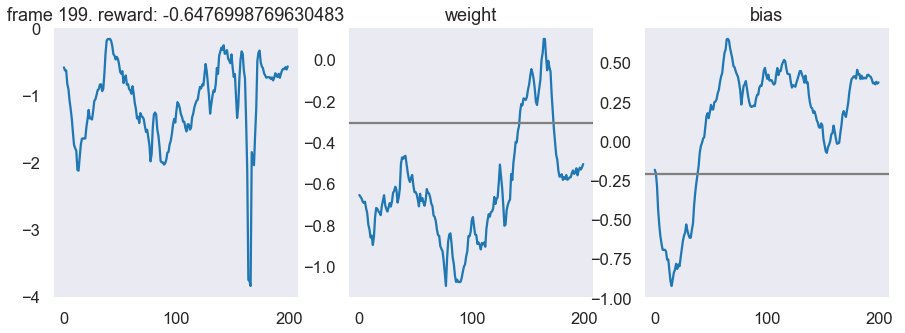

In [241]:
learn(200)

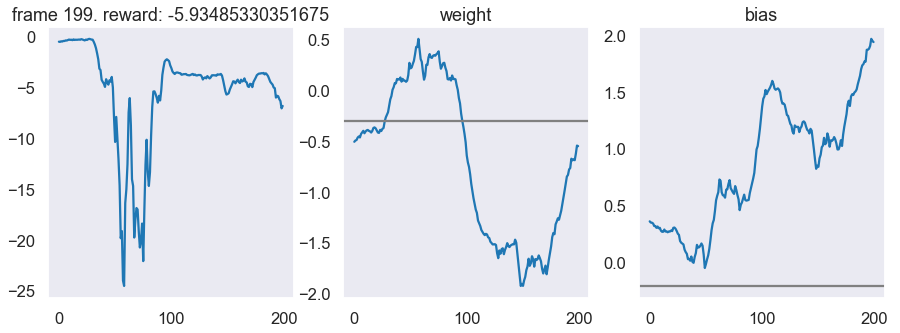

In [243]:
learn(200, 200*1000)

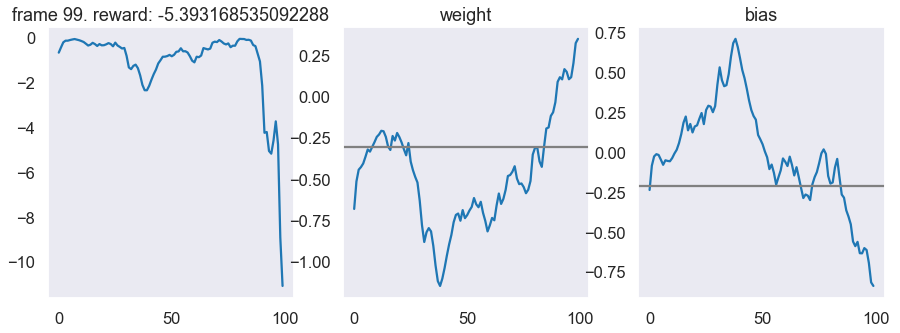

In [210]:
error = []
weights = []
biases = []
tbar = tqdm(range(nepisodes))
for episode in tbar:
    # Start a new run!
    l96_param = L96TwoLevelRL(noYhist=True, parameterization=nn_param, 
                            X_init=initX, Y_init=initY)
    state = l96_param.X
    for step in range(nsteps):
        action = policy_net(torch.FloatTensor(state)[:, None].to(device)).cpu().detach().numpy()[:, 0]
        action += np.random.normal(0, noise, action.shape)
        l96_param.step_with_B(action)
        next_state = l96_param.X
        if step == (nsteps-1):
            done = 1
            reward = -((l96_param.X - X_tru)**2).mean()
            error.append(reward)
            weights.append(nn_param.net.linear.weight.cpu().detach().numpy()[0])
            biases.append(nn_param.net.linear.bias.cpu().detach().numpy()[0])
            plot(episode, error, weights, biases)
        else:
            done = 0
            reward = 0
        replay_buffer.push(state, action, [reward]*l96_param.K, next_state, [done]*l96_param.K)
        
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
            
        state = next_state

    tbar.set_description(str(reward))
